<a href="https://colab.research.google.com/github/naldo14/tesis-/blob/main/filtro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import sys
import h5py #librerua para crear archivos , h5py

In [ ]:
#hacer el mounted de mi cuenta drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sys.path.insert(0,"/content/drive/My Drive/Colab Notebooks")
import unzipmodule
import graficador

In [54]:
#### creo una clase asociada al filtro pasa bajo
import matplotlib.pyplot as plt
class low_band_filter:
  def __init__(self, siganl_1,N, cutoff,sampling_frecuencie):
    self.signal_1=signal_1
    self.order=N
    self.cutoff=cutoff
    self.sampling_frecuencie=sampling_frecuencie
    self.sos = None  # Initialize sos as None

  def filter_making(self):
    fnqy=self.sampling_frecuencie/2
    b, a = signal.butter(self.order,self.cutoff/fnqy, 'low', True) #coeficientes de la funcion de transferencia
    w, h = signal.freqs(b, a)
    self.sos = signal.butter(self.order, self.cutoff/fnqy, analog=False, btype='low', output='sos')
    return(w,h)
  def filtered_signal(self):
    filtered = signal.sosfilt(self.sos, self.signal_1)
    return(filtered)


#### creo una clase asociada al filtro pasa banda
class pass_band_filter:
  def __init__(self, siganl_1,wp,ws,sampling_frecuencie):
    self.signal_1=signal_1
    self.wp=wp
    self.ws=ws
    self.sampling_frecuencie=sampling_frecuencie
    self.sof=None

  def filter_making(self):
    fnqy=self.sampling_frecuencie/2
    N, Wn = signal.buttord([self.wp[0]/fnqy,self.wp[1]/fnqy], [self.ws[0]/fnqy, self.ws[1]/fnqy], 3, 40, True)
    b, a = signal.butter(N, Wn, 'bandpass', True)
    w, h = signal.freqs(b, a)
    self.sos=signal.butter(N, Wn,  analog=False, btype='bandpass', output='sos')
    return(w,h)
  def filtered_signal(self):
    filtered = signal.sosfilt(self.sos, self.signal_1)
    return(filtered)

#### creo una clase asociada al filtro pasa banda
class stop_band_filter:
  def __init__(self, siganl_1,wp,ws,sampling_frecuencie):
    self.signal_1=signal_1
    self.wp=wp
    self.ws=ws
    self.sampling_frecuencie=sampling_frecuencie
    self.sof=None

  def filter_making(self):
    fnqy=self.sampling_frecuencie/2
    N, Wn = signal.buttord([self.wp[0]/fnqy,self.wp[1]/fnqy], [self.ws[0]/fnqy, self.ws[1]/fnqy], 3, 40, True)
    b, a = signal.butter(N, Wn, 'bandstop', True)
    w, h = signal.freqs(b, a)
    self.sos=signal.butter(N, Wn,  analog=False, btype='bandstop', output='sos')
    return(w,h)
  def filtered_signal(self):
    filtered = signal.sosfilt(self.sos, self.signal_1)
    return(filtered)




In [58]:
def graph_maker(w, h, filter_type, sampling_frequency):
    fnqy = sampling_frequency / 2

    if filter_type == 'low':
        title = 'Butterworth lowpass filter'
    elif filter_type == 'bandpass':
        title = 'Butterworth bandpass filter'
    else:
        title = 'Butterworth stopband filter'

    plt.figure(figsize=(10, 6))

    plt.subplot(2, 1, 1)
    plt.plot(w * fnqy, 20 * np.log10(abs(h)))
    plt.title(title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.grid(True)
    plt.axis([1,250, -60, 3])

    plt.subplot(2, 1, 2)
    angles = np.unwrap(np.angle(h))
    plt.plot(w * fnqy, angles)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase (radians)')
    plt.grid(True)
    plt.axis([1, 200, -60, 3])

    plt.tight_layout()
    plt.show()


In [29]:
def graph_function(t, signal_1, filtered, type_filter):
    if type_filter == "low":
        title = "After low-pass filter using sos"
    elif type_filter == "bandpass":
        title = "After band-pass filter using sos"
    else:
        title = "After band-stop filter using sos"

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1.plot(t, signal_1)
    ax1.set_title('Señal sin filtro')
    ax1.axis([0, 1, -2, 2])

    ax2.plot(t, filtered)
    ax2.set_title(title)
    ax2.set_xlabel('Time [seconds]')
    ax2.axis([0, 1, -2, 2])

    plt.tight_layout()
    plt.show()


In [85]:
def fft_function(fs, signal_1, t):
    n = len(signal_1)
    k = np.arange(n)
    T = n / fs
    frq = k / T  # Two sides frequency range

    Y = np.fft.fft(signal_1) / n  # FFT computing and normalization
    Y = Y[:n // 2]  # Take only the first half (positive frequencies)

    # Plot the original signal and its FFT
    plt.subplot(2, 1, 1)
    plt.plot(t, signal_1)
    plt.title('Original Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    plt.subplot(2, 1, 2)
    plt.plot(frq[:n//2], abs(Y))
    plt.title('FFT of the Signal')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()


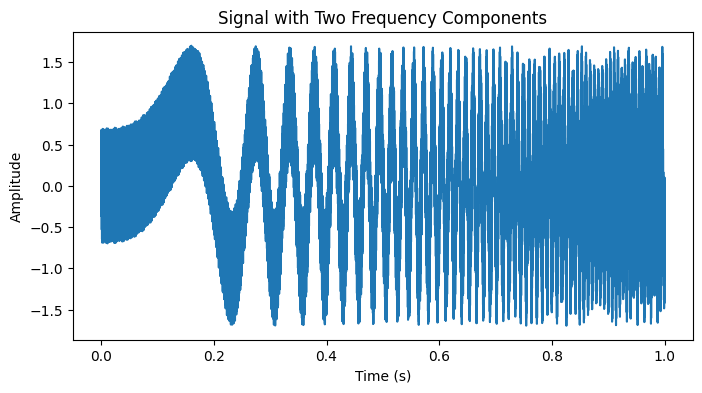

In [87]:
duration = 1  # Duration of the signal (seconds)
fs = 25.6e3 # Sampling rate (Hz
t = np.linspace(0, duration, int(fs * duration))
f1=60*t**2
f2=60*7
f3=3e3
signal_1 = np.sin(2 * np.pi * f1 * t) +0.2* np.sin(2 * np.pi * f2 * t)+0.5* np.sin(2 * np.pi * f3 * t)
plt.figure(figsize=(8, 4))
plt.plot(t, signal_1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Signal with Two Frequency Components')
plt.show()

**Filtro pasa bajo**:

1.    diagrama de bode de fase y magnitud
2.   señal antes y despues del filtrado
3.  fft de la señal sin filtrar y despues de filtrar


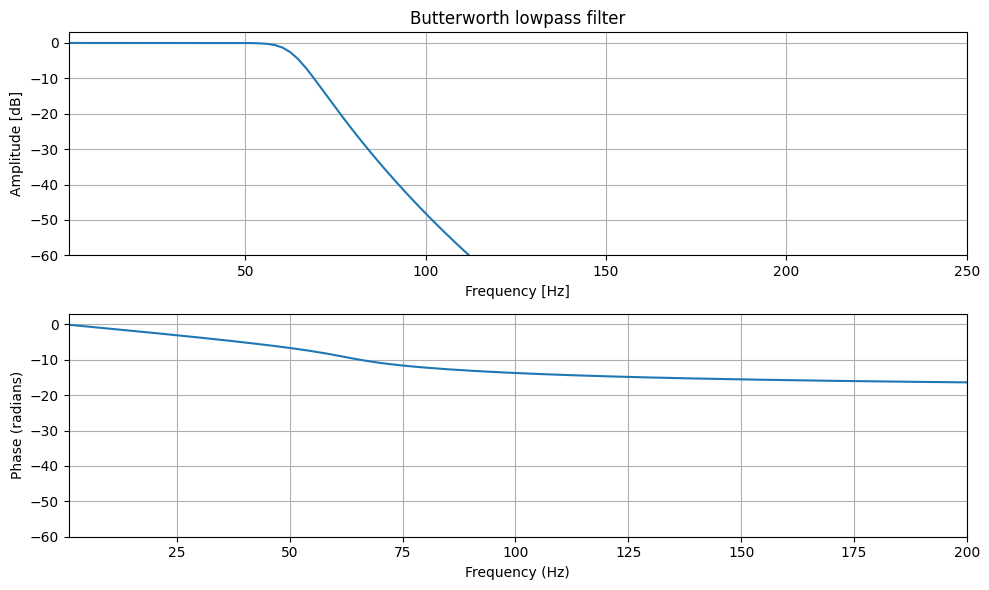

In [101]:
#pruebo el filtro pasa bajo
first_filter=low_band_filter(signal_1,12,63,25.6e3)
w,h=first_filter.filter_making()
graph_maker(w, h, "low",25.6e3)


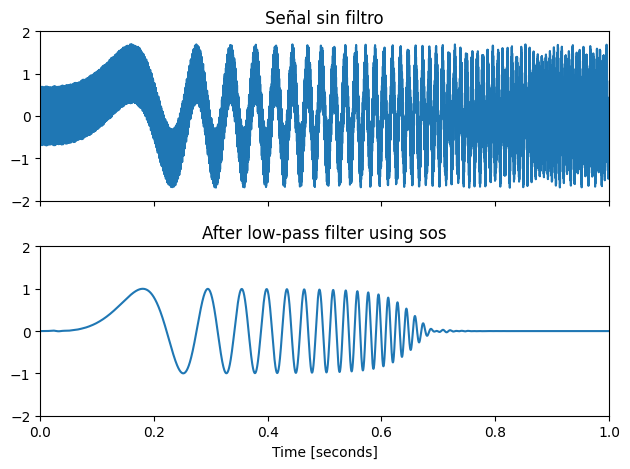

In [103]:
filtered_1=first_filter.filtered_signal()
graph_function(t, signal_1, filtered_1, "low")

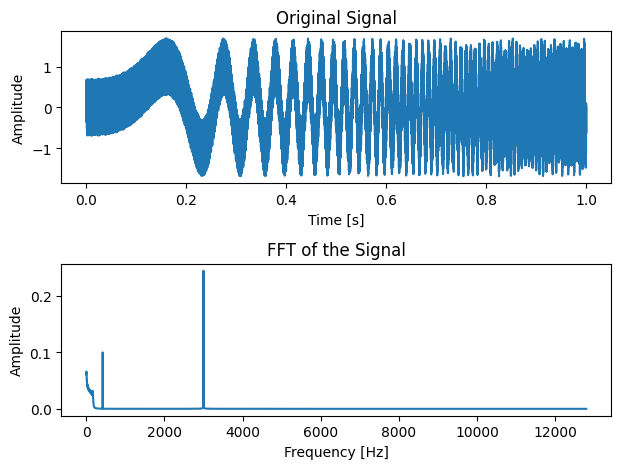

In [90]:
fft_function(fs, signal_1, t)

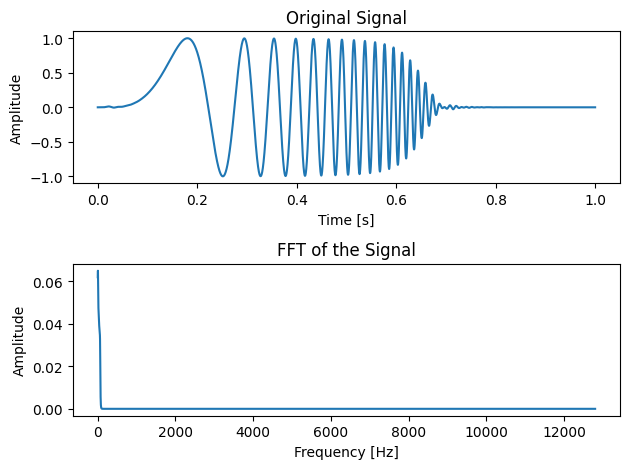

In [91]:
fft_function(fs,filtered, t)

**Filtro pasa banda**:

1.    diagrama de bode de fase y magnitud
2.   señal antes y despues del filtrado
3.  fft de la señal sin filtrar y despues de filtrar





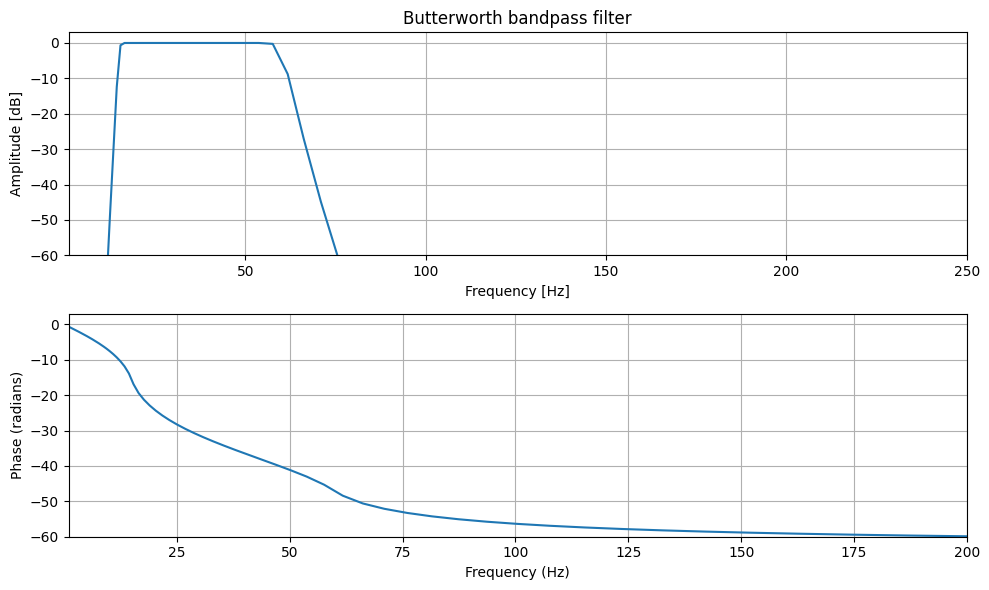

In [92]:
wp=[15,60]
ws=[10,70]
second_filter=pass_band_filter(signal_1,wp,ws,25.6e3)
w,h=second_filter.filter_making()
graph_maker(w, h, "bandpass",25.6e3)

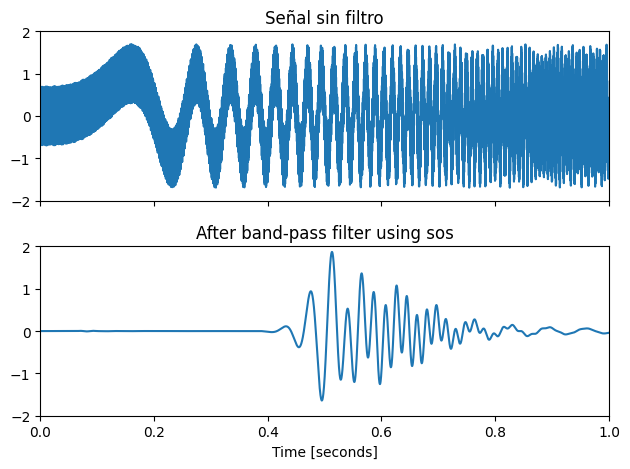

In [93]:
filtered=second_filter.filtered_signal()
graph_function(t, signal_1, filtered, "bandpass")

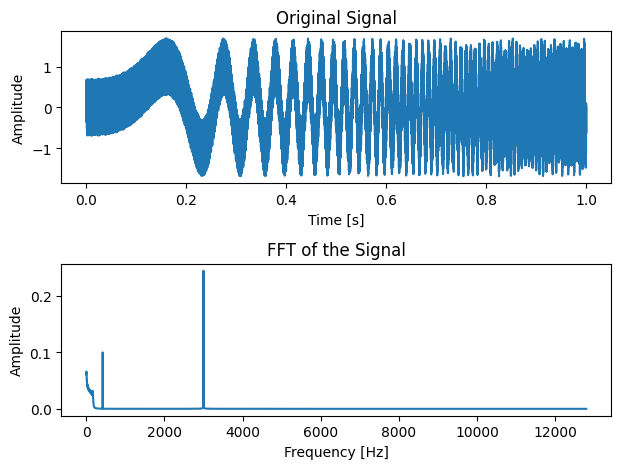

In [94]:
fft_function(fs, signal_1, t)

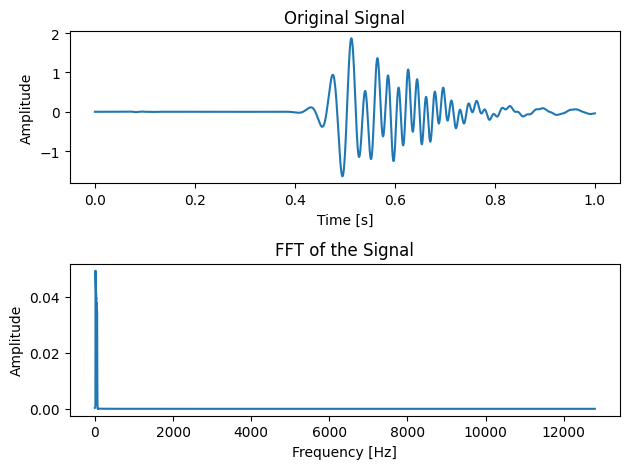

In [95]:
fft_function(fs,filtered, t)

**Filtro elimina banda**:

1.    diagrama de bode de fase y magnitud
2.   señal antes y despues del filtrado
3.  fft de la señal sin filtrar y despues de filtrar


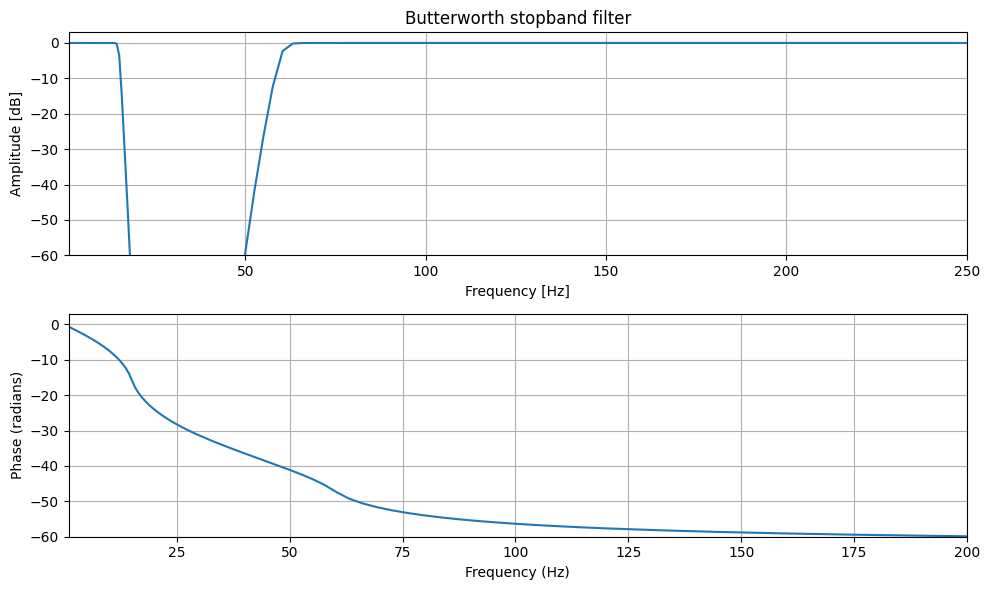

In [96]:
wp=[15,60]
ws=[10,70]
third_filter=stop_band_filter(signal_1,wp,ws,25.6e3)
w,h=third_filter.filter_making()
graph_maker(w, h, "bandstop",25.6e3)

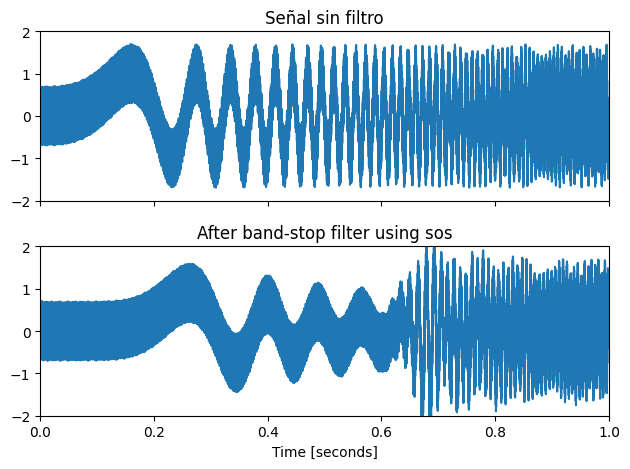

In [99]:
filtered=third_filter.filtered_signal()
graph_function(t, signal_1, filtered, "bandstop")

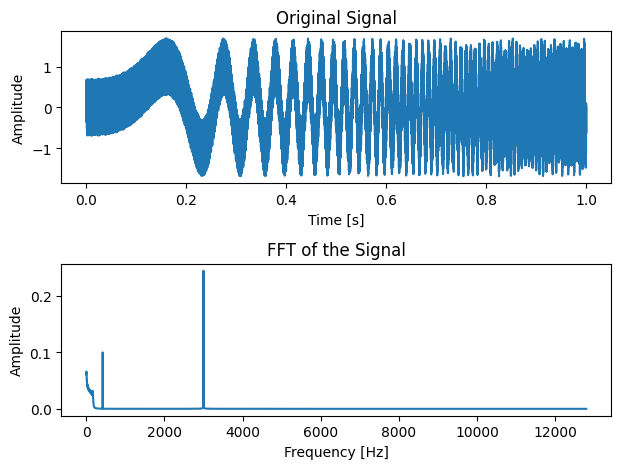

In [98]:
fft_function(fs, signal_1, t)

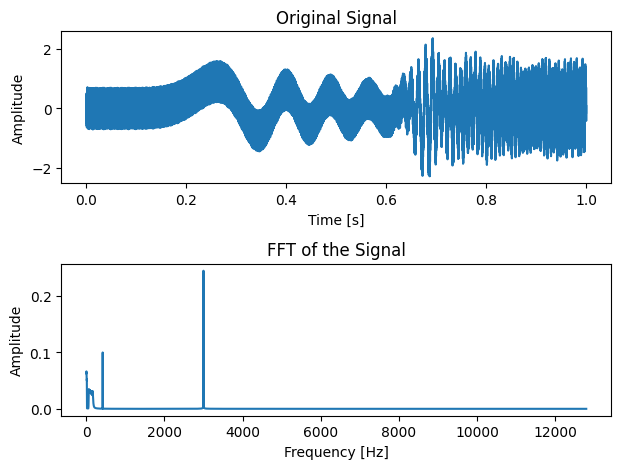

In [100]:
fft_function(fs,filtered, t)

**Calculo de las cwt de la señal despues de ser filtrada por un pasabajo a 63 Hz**

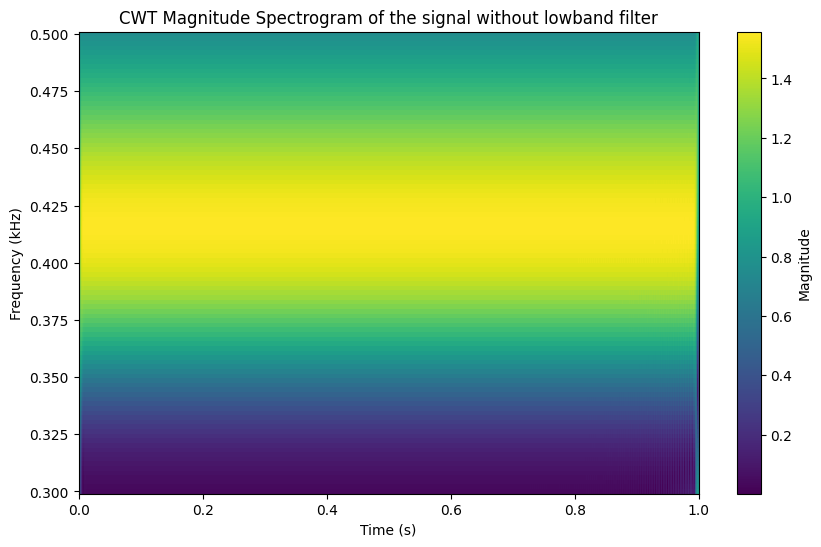

In [ ]:
----------------------------------------
from scipy import signal
w =7
freq = np.linspace(300,500, 100)
widths = w*fs / (2*freq*np.pi)
cwtm = signal.cwt(signal_1, signal.morlet2, widths, w=w)


plt.figure(figsize=(10, 6))
plt.pcolormesh(t, freq/1e3, np.abs(cwtm), cmap='viridis', shading='auto')
plt.colorbar(label='Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.title('CWT Magnitude Spectrogram of the signal without lowband filter')
plt.show()

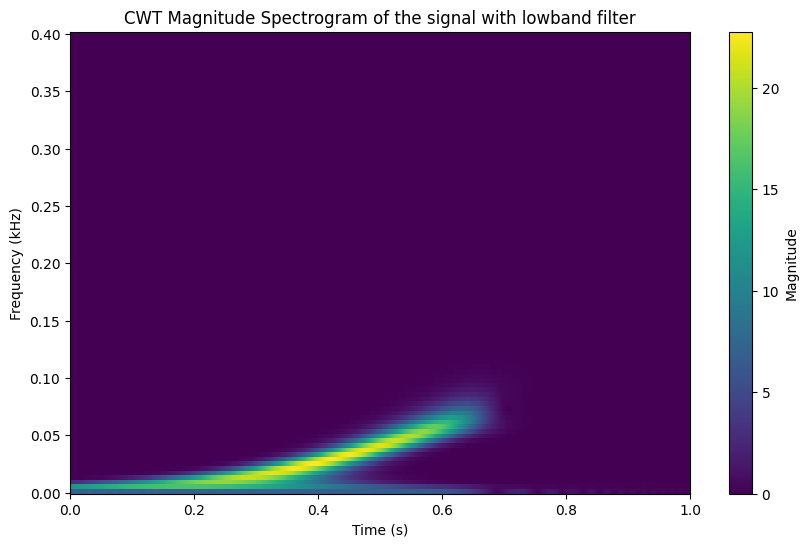

In [105]:
from scipy import signal
w =7
freq = np.linspace(1,400, 100)
widths = w*fs / (2*freq*np.pi)
cwtm = signal.cwt(filtered_1 , signal.morlet2, widths, w=w)
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, freq/1e3, np.abs(cwtm), cmap='viridis', shading='auto')
plt.colorbar(label='Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.title('CWT Magnitude Spectrogram of the signal with lowband filter')
plt.show()

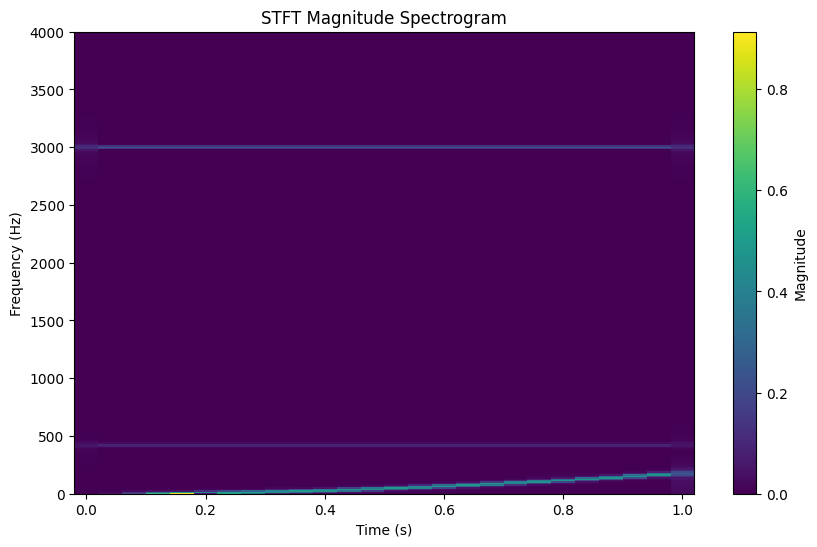

In [ ]:
from scipy.signal import stft
frequencies, time_points, magnitude = stft(signal_1, fs, window='hann', nperseg=2048, noverlap= 1024)

# Plot the magnitude spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(time_points, frequencies, np.abs(magnitude), shading='auto')
plt.colorbar(label='Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('STFT Magnitude Spectrogram')
fs_limit=4e3
plt.ylim(0, fs_limit)  # Set the frequency range for visualization
plt.show()

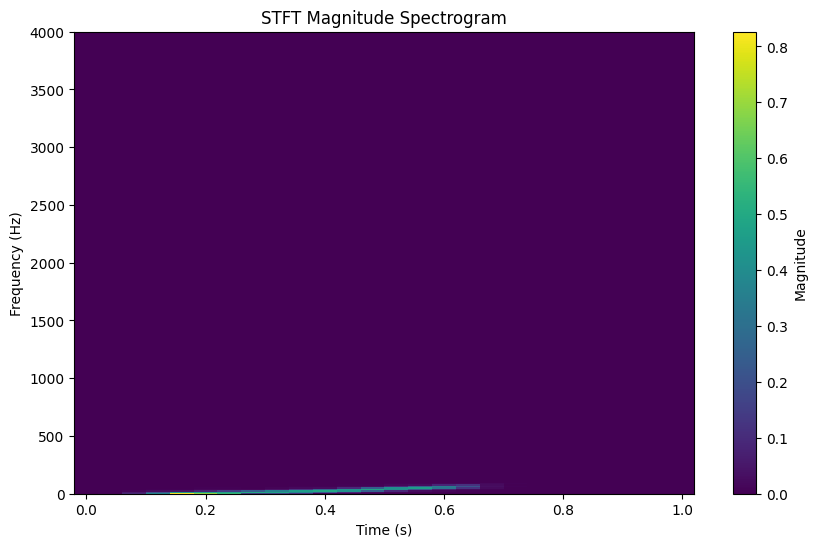

In [ ]:
from scipy.signal import stft
frequencies, time_points, magnitude = stft(filtered, fs, window='hann', nperseg=2048, noverlap= 1024)

# Plot the magnitude spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(time_points, frequencies, np.abs(magnitude), shading='auto')
plt.colorbar(label='Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('STFT Magnitude Spectrogram')
fs_limit=4e3
plt.ylim(0, fs_limit)  # Set the frequency range for visualization
plt.show()